## Fitting and error estimation with MCMC

-- F. Acero, March 2019 --

The goal of Markov Chain Monte Carlo (MCMC) algorithms is to approximate the posterior distribution of your model parameters by random sampling in a probabilistic space. For most readers this sentence was probably not very helpful so here we'll start straight with and example but you should read the more detailed mathematical approaches of the method [here](https://www.pas.rochester.edu/~sybenzvi/courses/phy403/2015s/p403_17_mcmc.pdf) and [here](https://github.com/jakevdp/BayesianAstronomy/blob/master/03-Bayesian-Modeling-With-MCMC.ipynb).


### How does it work ?

The idea is that we use a number of walkers that will sample the posterior distribution (i.e. sample the Likelihood profile).

The goal is to produce a "chain", i.e. a list of $\theta$ values, where each $\theta$ is a vector of parameters for your model.<br>
If you start far away from the truth value, the chain will take some time to converge until it reaches a stationary state. Once it has reached this stage, each successive elements of the chain are samples of the target posterior distribution.<br>
This means that, once we have obtained the chain of samples, we have everything we need. We can compute the  distribution of each parameter by simply approximating it with the histogram of the samples projected into the parameter space. This will provide the errors and correlations between parameters.


Now let's try to put a picture on the ideas described above. With this notebook, we have simulated and carried out a MCMC analysis for a source with the following parameters:<br>
$Index=2.0$, $Norm=5\times10^{-12}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$, $Lambda =(1/Ecut) = 0.02$ TeV$^{-1}$ (50 TeV) for 20 hours.

The results that you can get from a MCMC analysis will look like this :

<img src="images/MCMC-gammapy.png" width="800">

On the first two top panels, we show the pseudo-random walk of one walker from an offset starting value to see it evolve to a better solution.
In the bottom right panel, we show the trace of each 16 walkers for 500 runs (the chain described previsouly). For the first 100 runs, the parameter evolve towards a solution (can be viewed as a fitting step). Then they explore the local minimum for 400 runs which will be used to estimate the parameters correlations and errors.
The choice of the Nburn value (when walkers have reached a stationary stage) can be done by eye but you can also look at the autocorrelation time.



### Why should I use it ?

When it comes to evaluate errors and investigate parameter correlation, one typically estimate the Likelihood in a gridded search (2D Likelihood profiles). Each point of the grid implies a new model fitting. If we use 10 steps for each parameters, we will need to carry out 100 fitting procedures. 

Now let's say that I have a model with $N$ parameters, we need to carry out that gridded analysis $N*(N-1)$ times. 
So for 5 free parameters you need 20 gridded search, resulting in 2000 individual fit. 
Clearly this strategy doesn't scale well to high-dimensional models.

Just for fun: if each fit procedure takes 10s, we're talking about 5h of computing time to estimate the correlation plots. 




There are many MCMC packages in the python ecosystem but here we will focus on [emcee](http://url), a lightweight Python package. A description is provided here : [Foreman-Mackey, Hogg, Lang & Goodman (2012)](https://arxiv.org/abs/1202.3665).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import sys

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.cube.models import SkyModel, SkyModels, BackgroundModel
from gammapy.cube import MapDataset, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.cube.simulate import simulate_dataset
from gammapy.utils.fitting import Fit

import emcee

## Simulate an observation

Here we will start by simulating an observation using the `simulate_dataset` method.

In [2]:
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)

In [3]:
# Define sky model to simulate the data
spatial_model = SkyGaussian(lon_0="0 deg", lat_0="0 deg", sigma="0.2 deg")

spectral_model = ExponentialCutoffPowerLaw( index=2, amplitude="3e-12 cm-2 s-1 TeV-1",
                                           reference="1 TeV", lambda_= '0.02 TeV-1' )

sky_model_simu = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)
print(sky_model_simu)

SkyModel

Parameters: 

	   name     value   error      unit         min        max    frozen
	--------- --------- ----- -------------- ---------- --------- ------
	    lon_0 0.000e+00   nan            deg -1.800e+02 1.800e+02  False
	    lat_0 0.000e+00   nan            deg -9.000e+01 9.000e+01  False
	    sigma 2.000e-01   nan            deg  0.000e+00       nan  False
	    index 2.000e+00   nan                       nan       nan  False
	amplitude 3.000e-12   nan cm-2 s-1 TeV-1        nan       nan  False
	reference 1.000e+00   nan            TeV        nan       nan   True
	  lambda_ 2.000e-02   nan          TeV-1        nan       nan  False


In [4]:
# Define map geometry
# We use energy bins from 0.1 to 300 TeV
axis = MapAxis.from_edges(
    np.logspace(-1, 2.5, 50), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.05, width=(2,2), coordsys="GAL", axes=[axis]
)

# Define some observation parameters
pointing = SkyCoord(0 *u.deg,0 *u.deg,frame='galactic') 


dataset = simulate_dataset(
    sky_model_simu, geom, pointing, irfs, livetime=20 * u.h, random_state=42
)



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x119786ac8>)

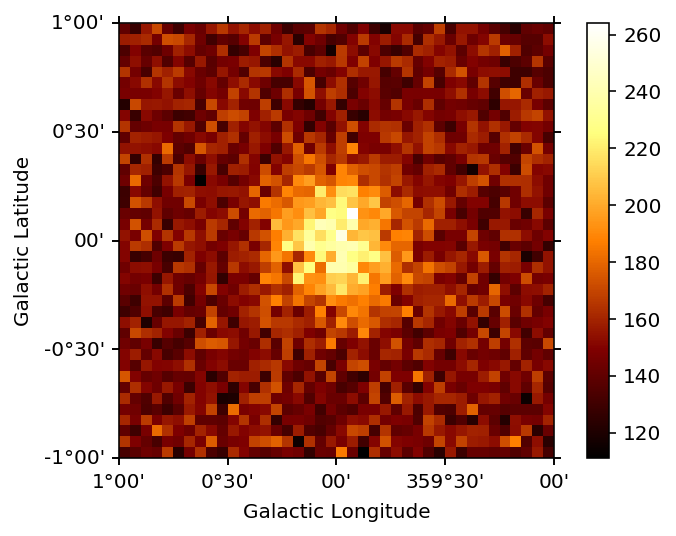

In [5]:
dataset.counts.sum_over_axes().plot(add_cbar=True)

In [6]:
#%%time
#fit = Fit(dataset)
#result = fit.run(optimize_opts={"print_level": 1})
#
#print(dataset.model)

## Estimate parameter correlations with MCMC

Now let's analyse the simulated data.
Here we just fit it again with the same model we had before as a starting point.
The data that would be needed are the following: 
- counts cube, psf cube, exposure cube and background model

Luckily all those maps are already in the Dataset object.

We will need to define a Likelihood function and define priors on parameters.<br>
Here we will assume a uniform prior reading the min, max parameters from the sky model.


In [7]:
# Prior functions

def uniform_prior(value, umin, umax):
    """Uniform prior distribution.
    """
    if umin <= value <= umax:
        return 0.0
    else:
        return -np.inf

def normal_prior(value, mean, sigma):
    """Normal prior distribution.
    """
    return -0.5 * (2 * np.pi * sigma) - (value - mean)**2 / (2. * sigma)

In [8]:

def model_to_par(dataset):
    """
    Return a tuple of the factor parameters of all 
    free parameters in the dataset sky model.
    """
    pars=[]
    for p in dataset.parameters.free_parameters:
            pars.append(p.factor)

    return pars

def lnprior(dataset):
    """
    Return probability of parameter values according to prior knowledge.
    Parameter limits should be done here through uniform prior ditributions
    """
    
    logprob=0
    for par in dataset.parameters.free_parameters:
        logprob += uniform_prior(par.value,par.min,par.max) #Should it read value or factor after autoscale?
    
    return logprob


def lnprob(pars,dataset,verb=False):
    """
    Estimate the likelihood of a model including prior on parameters.
    """
    
    
    #Update model parameters factors inplace
    for factor, par in zip(pars,dataset.parameters.free_parameters):
        par.factor = factor
    
    lnprob_priors = lnprior(dataset)    
    
    # None is not read. LL with current state of model in dataset
    # WARNING: dataset.likelihood returns Cash statistics values
    # emcee will maximisise the LogLikelihood so we need -dataset.likelihood
    total_lnprob = -dataset.likelihood(None) + lnprob_priors  

    
    if verb:
        print("Parameters are:",pars)    
        print('LL=',total_lnprob)
        for p in dataset.parameters.free_parameters:
            print(p)
        print("")
        
    return total_lnprob

### Define priors

This steps is a bit manual for the moment until we find a better API to define priors.<br>
Note the you **need** to define priors for each parameter otherwise your walkers can explore uncharted territories (e.g. negative norms).

In [9]:
# Define the free parameters and min, max values

dataset.parameters["sigma"].frozen = True
dataset.parameters["lon_0"].frozen = True
dataset.parameters["lat_0"].frozen = True
dataset.parameters["amplitude"].frozen = False
dataset.parameters["index"].frozen = False
dataset.parameters["lambda_"].frozen = False

#Currently bkg parameters does not appear in dataset.parameters.free_parameters 
#This is normal are these parameters are in dataset.background_model.parameters
#Not sure how to access them easily. Freezing Bkg parameter for now
dataset.background_model.parameters["norm"].frozen = True
dataset.background_model.parameters["tilt"].frozen = True

dataset.parameters["index"].min = 1
dataset.parameters["index"].max = 5
dataset.parameters["lambda_"].min = 0
dataset.parameters["lambda_"].max = 1

dataset.parameters["amplitude"].min = 0.01 *dataset.parameters["amplitude"].value
dataset.parameters["amplitude"].max = 100  *dataset.parameters["amplitude"].value

dataset.parameters["sigma"].min = 0.05
dataset.parameters["sigma"].max = 1

#dataset.parameters = sky_model.parameters # update dataset with the param that we want to use
#dataset.model = sky_model # update dataset with the model that we want to use
#How do I update the sky model of an existing dataset ?
# The lines above update the model but the dataset gives always the same likelihood, indep of new model

dataset.parameters['index'].value=2.1
dataset.parameters['amplitude'].value=4e-12
dataset.parameters['lambda_'].value=0.02

print(dataset.model)
print('LL =',dataset.likelihood(dataset.parameters))


SkyModels

Component 0: SkyModel

Parameters: 

	   name     value   error      unit         min        max    frozen
	--------- --------- ----- -------------- ---------- --------- ------
	    lon_0 0.000e+00   nan            deg -1.800e+02 1.800e+02   True
	    lat_0 0.000e+00   nan            deg -9.000e+01 9.000e+01   True
	    sigma 2.000e-01   nan            deg  5.000e-02 1.000e+00   True
	    index 2.100e+00   nan                 1.000e+00 5.000e+00  False
	amplitude 4.000e-12   nan cm-2 s-1 TeV-1  3.000e-14 3.000e-10  False
	reference 1.000e+00   nan            TeV        nan       nan   True
	  lambda_ 2.000e-02   nan          TeV-1  0.000e+00 1.000e+00  False

	


LL = -754667.640252431


In [10]:
# Now let's define a function to init parameters and run the MCMC with emcee
# Depending on your number of walkers, Nrun and dimensionality, this can take a while (> minutes)

def run_mcmc(dataset,nwalkers=12,nrun=500,threads=1):
    """
    
    dataset:
    A gammapy dataset object. This contains the observed counts cube,
    the exposure cube, the psf cube, and the sky model and model.
    Each free parameter in the sky model is considered as parameter for the MCMC.
    
    nwalkers:
    Required integer number of walkers to use in ensemble.
    Minimum is 2*nparam+2, but more than that is usually better.
    Must be even to use MPI mode.
    
    nrun:
    Number of steps for walkers. Typically at least a few hundreds (but depends on dimensionality).
    Low nrun (<100?) will underestimate the errors. 
    Samples that would populate the distribution are nrun*nwalkers.
    This step can be ~seen as the error estimation step. 
    
    """
    
    
    dataset.parameters.autoscale() #Autoscale parameters
    pars=model_to_par(dataset) #get a tuple of parameters from dataset
    ndim=len(pars)

    # Initialize walkers in a ball of relative size 0.5% in all dimensions if the
    # parameters have been fit, or to 10% otherwise
    spread=0.5/100
    p0var = np.array([spread * pp for pp in pars])
    p0 = emcee.utils.sample_ball(pars, p0var, nwalkers)

    labels=[]
    for par in dataset.parameters.free_parameters:
        labels.append(par.name)
        if (par.min is np.nan) and (par.max is np.nan):
            print('Warning: no priors have been set for parameter %s\n The MCMC will likely not work !'%(par.name))

            
    print('List of free parameters:',labels)
    print('%i walkers will run for %s steps'%(nwalkers,nrun))
    print('Parameters init value for 1st walker:',p0[0])
    sampler = emcee.EnsembleSampler(nwalkers,
                                    ndim,
                                    lnprob,
                                    args=[dataset],
                                    threads=threads)

#    sampler.run_mcmc(p0,nrun)
    for i, result in enumerate(sampler.sample(p0, iterations=nrun)):
        if (i+1) % 100 == 0:
            print("{0:5.0%}".format(float(i) / nrun))


    return sampler

sampler=run_mcmc(dataset,nwalkers=8,nrun=500) # to speedup the notebook
#sampler=run_mcmc(dataset,nwalkers=16,nrun=1000) # more accurate contours


List of free parameters: ['index', 'amplitude', 'lambda_']
16 walkers will run for 1000 steps
Parameters init value for 1st walker: [2.11015766 4.01686525 1.99291145]
  10%
  20%
  30%
  40%
  50%
  60%
  70%
  80%
  90%
 100%


## Plotting the results

The MCMC will return a sampler object containing the trace of all walkers.<br>
The most important part is the chain attribute which is an array of shape:<br>
_(nwalkers, nrun, nfreeparam)_

The chain is then used to plot the trace of the walkers and estimate the burnin period (the time for the walkers to reach a stationary stage).

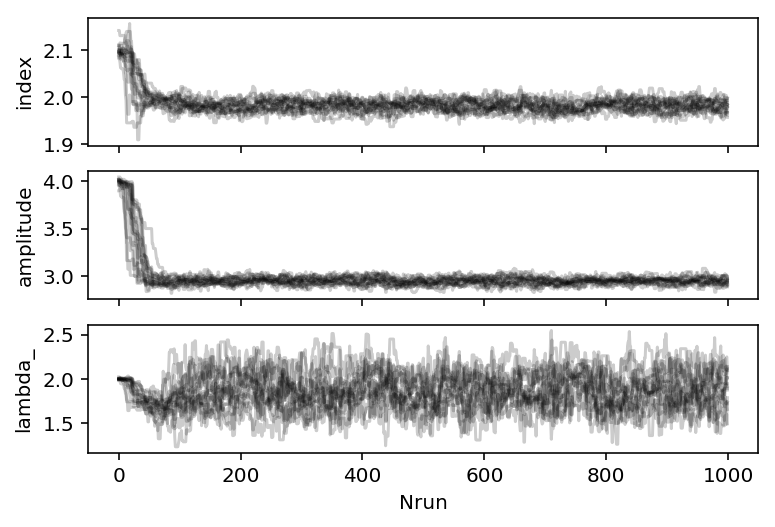

In [11]:

def plot_trace(sampler,dataset):
    """
    Plot the trace of walkers for every steps
    """
    labels=[]
    for par in dataset.parameters.free_parameters:
        labels.append(par.name)

    fig, ax = plt.subplots(len(labels), sharex=True)
    for i in range(len(ax)):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2)
        ax[i].set_ylabel(labels[i])
    plt.xlabel('Nrun')
    plt.show()
    
plot_trace(sampler,dataset)

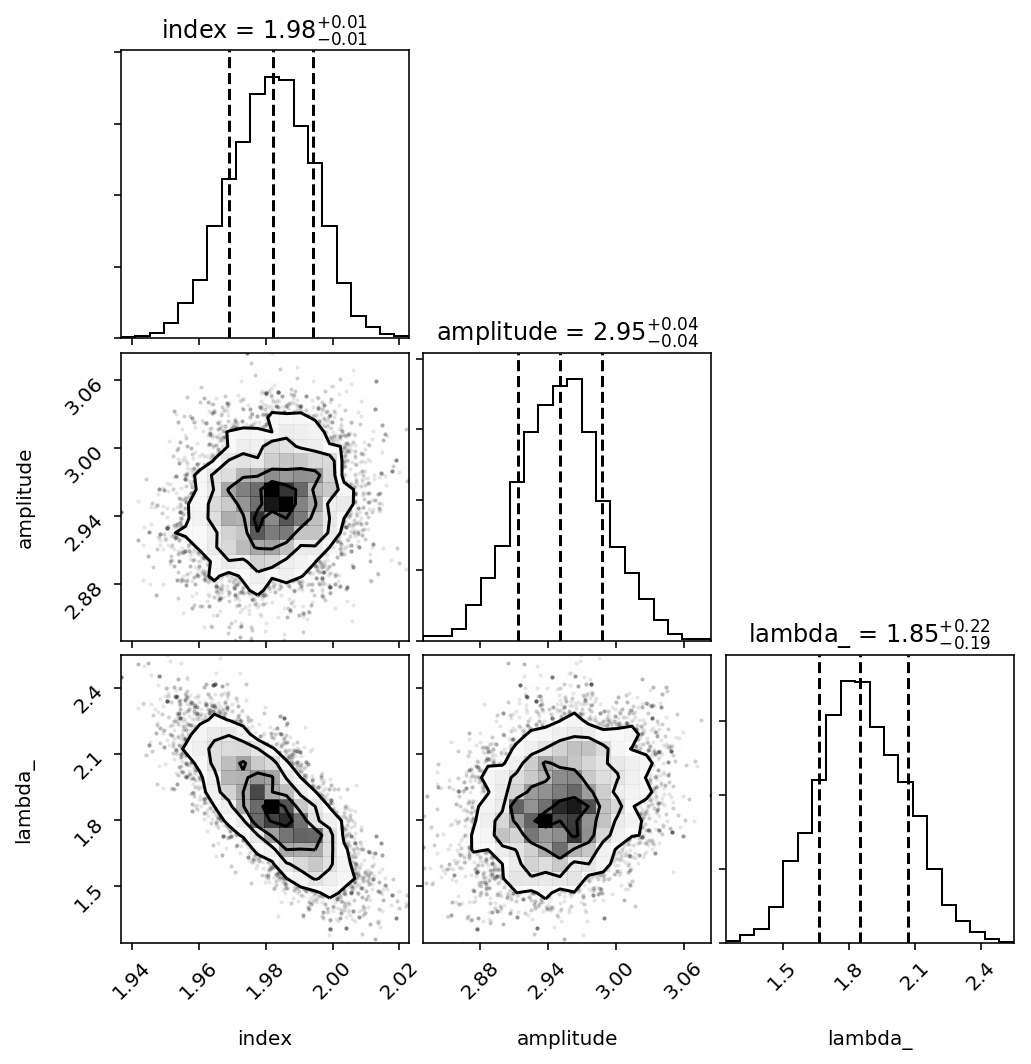

In [12]:

def plot_corner(sampler,dataset,nburn=0):
    """
    Corner plot for each parameter explored by the walkers
    
    nburn:
    Number of runs that will be discarded (burnt) until reaching ~stationary states for walkers.
    Hard to guess. Depends how close to best-fit you are. 
    A good nbrun value can be estimated from the trace plot.
    This step can be ~seen as the fitting step.    
    
    """
    import corner
    
    labels=[]
    for par in dataset.parameters.free_parameters:
        labels.append(par.name)
    
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(labels)))

    fig = corner.corner(samples,labels=labels,quantiles=[0.16, 0.5, 0.84],
                        show_titles=True)
    plt.show()
    
plot_corner(sampler,dataset,nburn=150)    

## Plotting the model dispersion
Using the samples from the chain after the burn period, we can plot the models on top of the data. To do this we need to compute an Npred for each parameter state in the sample. To do this efficiently one would need a function to easily update the sky model in the dataset from a list of parameters. Not sure how to do this.

# Fun Zone

Now that you have the sampler chain, you have in your hands the entire history of each walkers in the N-Dimensional parameter space. <br>
You can for example trace the steps of each walker in any parameter space.

Text(0, 0.5, 'Amplitude')

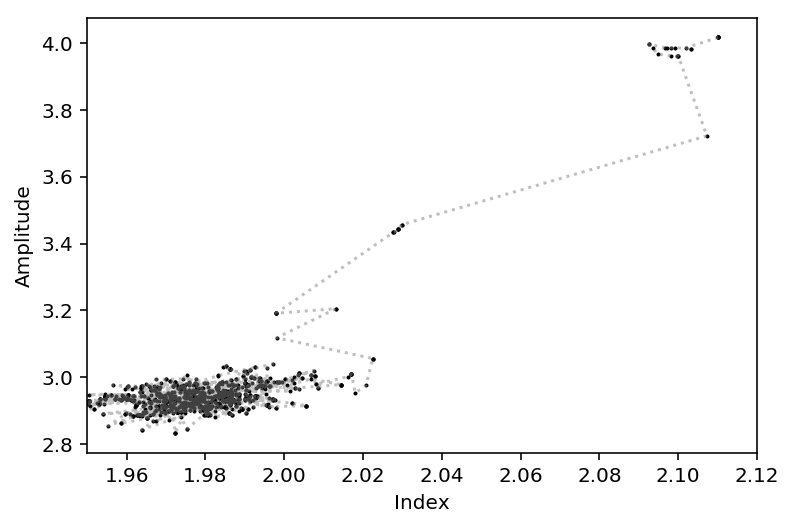

In [13]:
#Here we plot the trace of one walker in a given parameter space
parx=0
pary=1


plt.plot(sampler.chain[0,:,parx], sampler.chain[0,:,pary],'ko',ms=1)
plt.plot(sampler.chain[0,:,parx], sampler.chain[0,:,pary],ls=':',color='grey',alpha=0.5)
#plt.plot(1.955,2.705,'r+')
plt.xlim(1.95,2.12)
#plt.ylim(2.65,3.05)
plt.xlabel('Index')
plt.ylabel('Amplitude')

## PeVatrons in CTA ?

Now it's your turn to play with this MCMC notebook. For example to test the CTA performance to measure a cutoff at very high energies (100 TeV ?).